In [1]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

In [2]:
from IPython.display import Video

In [3]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 256, 256

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 10

# Specify the directory containing the dataset.
DATASET_DIR = "d:/Jupy/New folder (2)/Human Activity Recognition - Video Dataset"

CLASSES_LIST = sorted([entry.name for entry in os.scandir(DATASET_DIR) if entry.is_dir()])

In [6]:
CLASSES_LIST

['Clapping',
 'Jumping',
 'Meet and Split',
 'Running',
 'Sitting',
 'Standing Still',
 'Walking',
 'Walking While Reading Book',
 'Walking While Using Phone',
 'Waving']

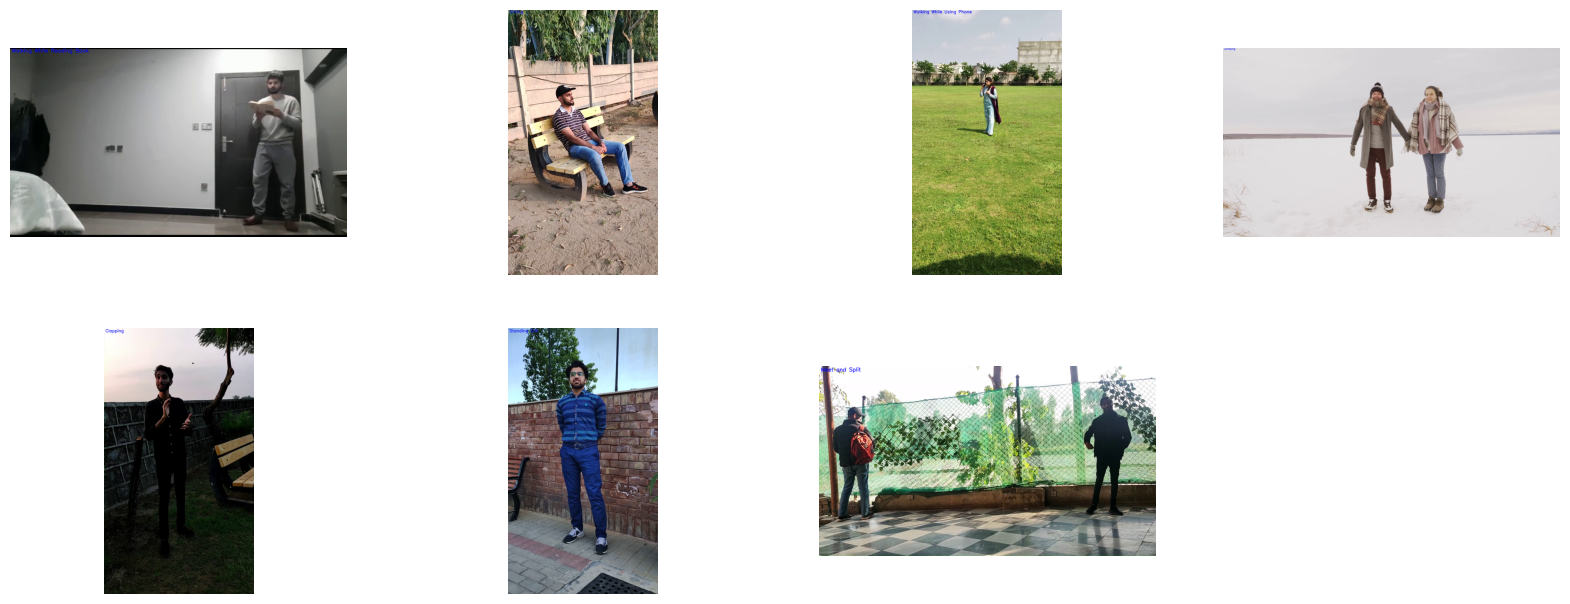

In [7]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir(DATASET_DIR)

random_range = random.sample(range(len(all_classes_names)), 7) 

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of a ll the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'{DATASET_DIR}/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{DATASET_DIR}/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [8]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [9]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Counter to keep track of the number of videos extracted for each class
        video_count = 0
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
                
                # Increment the video count
                video_count += 1
                
                # Break the loop if 15 videos have been extracted for the class
                if video_count == 50:
                    break
                # if you want to extract all the videos from all the classes
                # then remove this check, im working with 15 videos from each class to save time

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [10]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Clapping
Extracting Data of Class: Jumping
Extracting Data of Class: Meet and Split
Extracting Data of Class: Running
Extracting Data of Class: Sitting
Extracting Data of Class: Standing Still
Extracting Data of Class: Walking
Extracting Data of Class: Walking While Reading Book
Extracting Data of Class: Walking While Using Phone
Extracting Data of Class: Waving


In [11]:
print(len(features))

392


In [12]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [13]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [14]:
print(len(features_train[0]))

10


In [15]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [16]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [17]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

C:\Users\vinay\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 256, 256,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 64, 64, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 64, 64, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 64, 64, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 16, 16, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 10, 8, 8, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 10, 8, 8, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 10, 8, 8, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 10, 4, 4, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 10, 1024)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │       135,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,138 (766.16 KB)

 Trainable params: 196,138 (766.16 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


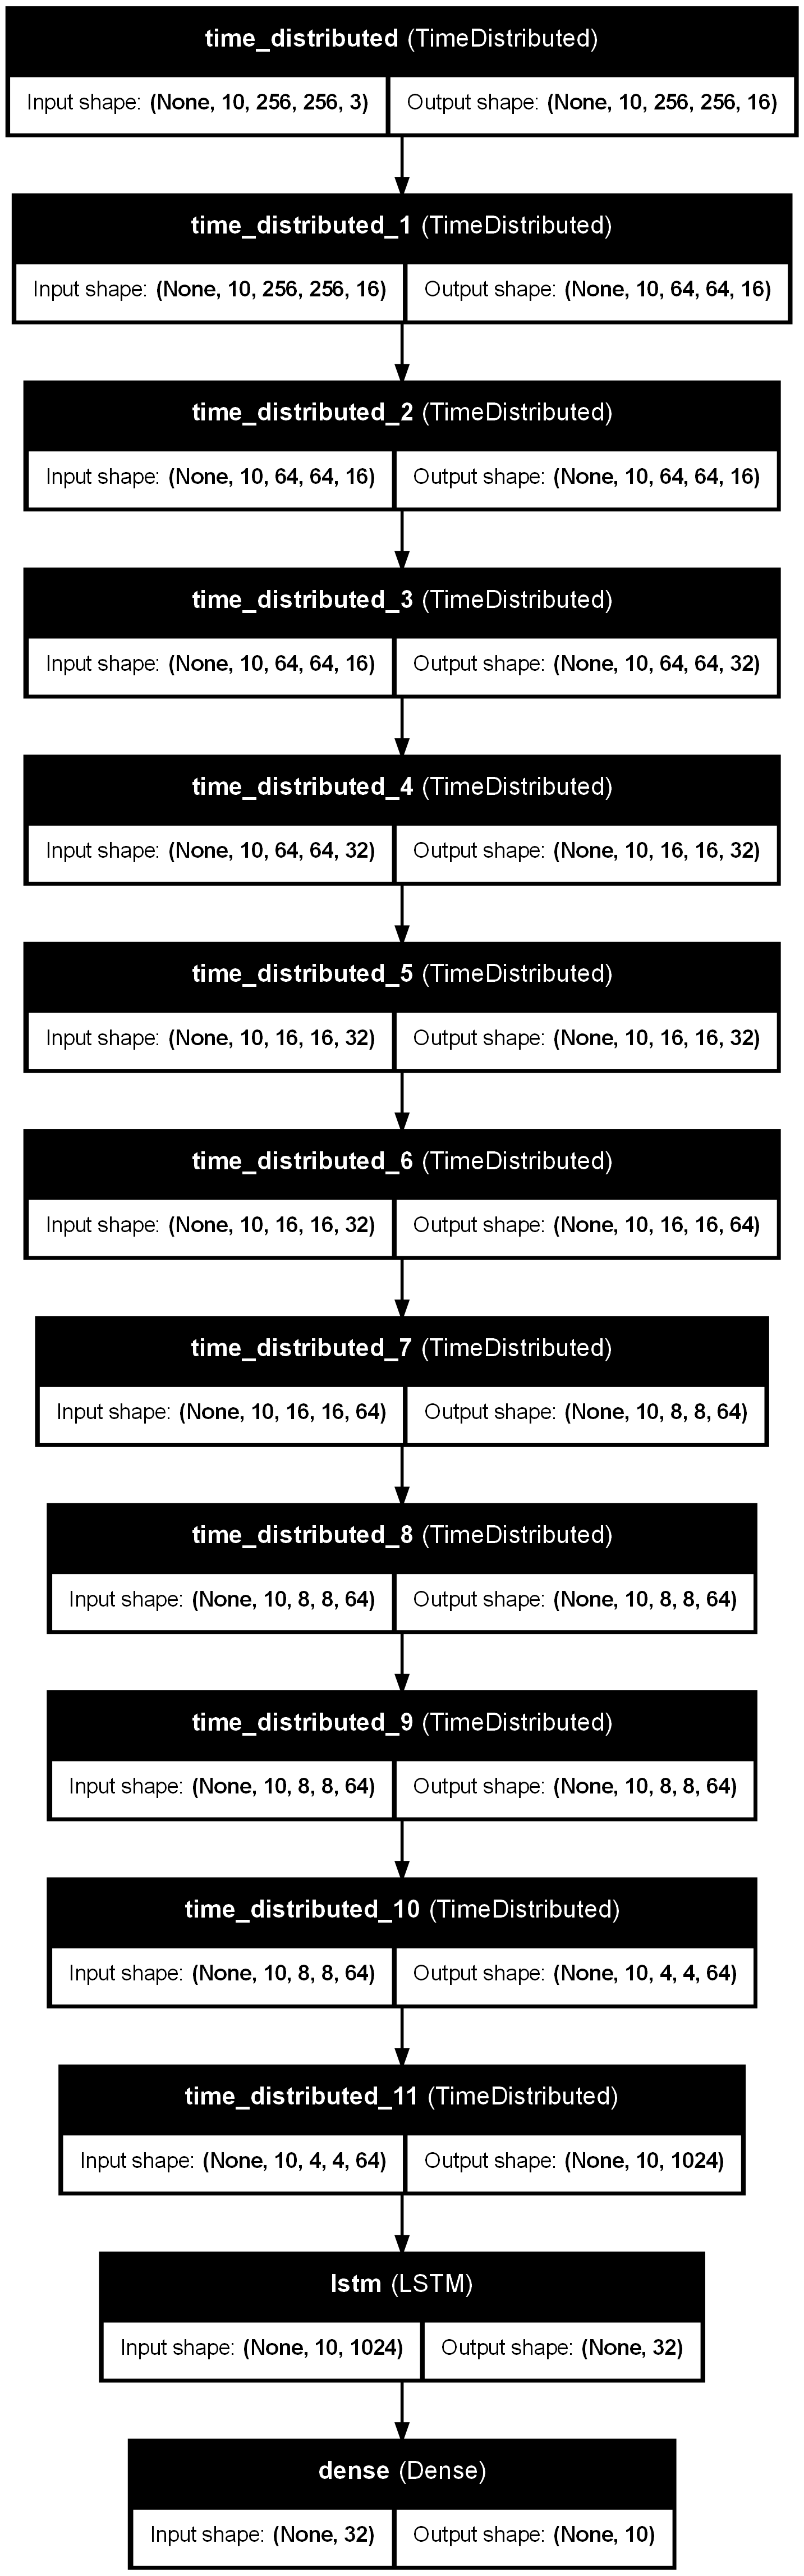

In [18]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [19]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 605ms/step - accuracy: 0.1468 - loss: 2.3247 - val_accuracy: 0.1017 - val_loss: 2.2364
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 560ms/step - accuracy: 0.1074 - loss: 2.2131 - val_accuracy: 0.2373 - val_loss: 2.1555
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 48s 810ms/step - accuracy: 0.1223 - loss: 2.1831 - val_accuracy: 0.1186 - val_loss: 2.1357
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.2101 - loss: 2.1111 - val_accuracy: 0.3220 - val_loss: 1.9294
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.2768 - loss: 1.9365 - val_accuracy: 0.4068 - val_loss: 1.7286
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.3902 - loss: 1.6997 - val_accuracy: 0.3729 - val_loss: 1.4983
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.5108 - loss: 1.5218 - val_accuracy: 0.4407 - val_loss: 1.4593
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.4783 - loss: 1.4242 - val_accura

59/59 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.9978 - loss: 0.0450 - val_accuracy: 0.8814 - val_loss: 0.3581
Epoch 52/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 343s 4s/step - accuracy: 0.9809 - loss: 0.1034 - val_accuracy: 0.9322 - val_loss: 0.2875
Epoch 53/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.9972 - loss: 0.0590 - val_accuracy: 0.8983 - val_loss: 0.3014
Epoch 54/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 357s 5s/step - accuracy: 0.9966 - loss: 0.0495 - val_accuracy: 0.9153 - val_loss: 0.2623
Epoch 55/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 299s 4s/step - accuracy: 1.0000 - loss: 0.0386 - val_accuracy: 0.9153 - val_loss: 0.2887
Epoch 56/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 443s 6s/step - accuracy: 1.0000 - loss: 0.0302 - val_accuracy: 0.8983 - val_loss: 0.2833
Epoch 57/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 0.8983 - val_loss: 0.2755
Epoch 58/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 299s 4s/step - accuracy: 1.0000 - loss: 0.0266 - val_accuracy: 0.8983 

In [20]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.8697 - loss: 0.3533


In [21]:
LRCN_model.save('d:/Jupy/New folder (2)/Saved/final.hdf5')
#loded_model = load_model('d:/Jupy/New folder (2)/Saved/1.hdf5')

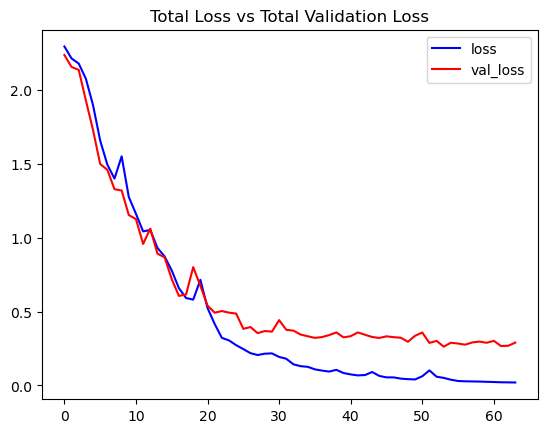

In [22]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

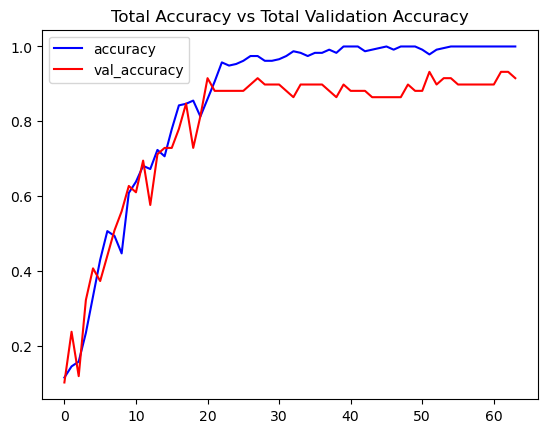

In [23]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Single video prediction function

In [ ]:
# Assume these constants are defined elsewhere in your code or script.
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
SEQUENCE_LENGTH = 10  # Example, set this to your required sequence length
# Ensure LRCN_model is loaded beforehand
LRCN_model = tf.keras.models.load_model('d:/Jupy/New folder (2)/Saved/1.hdf5')

def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function performs single action recognition prediction on a video using the LRCN model.
    
    Args:
    - video_file_path: The path to the video on which action recognition is to be performed.
    - SEQUENCE_LENGTH: The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
    
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
    
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Check if the video is too short to generate the required sequence of frames
    if video_frames_count < SEQUENCE_LENGTH:
        raise ValueError(f"The video is too short! It has {video_frames_count} frames, but {SEQUENCE_LENGTH} are required.")
    
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Iterating to extract the required number of frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # If the frame is not read properly, break the loop.
        if not success:
            raise ValueError(f"Frame could not be read at position {frame_counter * skip_frames_window}.")
        
        # Check if the frame is valid (not None).
        if frame is None:
            raise ValueError(f"Invalid frame detected at {frame_counter * skip_frames_window}.")

        # Resize the frame to match the input dimensions expected by the model.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the frame (pixel values between 0 and 1).
        normalized_frame = resized_frame / 255.0
        
        # Append the pre-processed frame to the frames list.
        frames_list.append(normalized_frame)

    # Ensure we collected enough frames
    if len(frames_list) != SEQUENCE_LENGTH:
        raise ValueError(f"Not enough frames were extracted! Expected {SEQUENCE_LENGTH} frames, but got {len(frames_list)}.")

    # Convert frames_list to numpy array and expand dimensions to add batch size dimension.
    frames_array = np.expand_dims(frames_list, axis=0)  # Shape: (1, SEQUENCE_LENGTH, 256, 256, 3)

    # Perform the prediction using the LRCN model.
    predicted_labels_probabilities = LRCN_model.predict(frames_array)[0]

    # Get the index of the class with the highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the predicted label index.
    if predicted_label >= len(CLASSES_LIST):
        raise IndexError(f"Predicted label {predicted_label} is out of range for CLASSES_LIST.")
    
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]:.2f}')

    # Release the VideoCapture object to free resources.
    video_reader.release()

    return predicted_class_name, predicted_labels_probabilities[predicted_label]


# test video

In [ ]:
# Construct tihe nput youtube video path
input_video_file_path = "d:/Jupy/New folder (2)/Human Activity Recognition - Video Dataset/lavish.mp4"
#print(os.listdir("d:/Jupy/New folder (2)/Human Activity Recognition - Video Dataset/Walking/"))
print(f"Classes available: {len(CLASSES_LIST)} - {CLASSES_LIST}")
# Perform Single Prediction on the Test Video.
prediction = predict_single_action(input_video_file_path, SEQUENCE_LENGTH)
predicted_label = np.argmax(prediction)  # or however you're getting the predicted label
print(f"Predicted label: {predicted_label}")
# Display the input video.
Video(input_video_file_path, embed=True, width=600)